In [ ]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

from scipy.stats import binom, norm

# Global parameters (without the bonus)

n_D = 100
n_max = 5 * 10**3
alpha_list = np.arange(0.75, 3.1, 0.25)
N_list = np.array([20, 40, 100])

# a-c)

Implement the required data generation and training routine via dedicated custom functions.

## Data generation

- $P$ data points
  - covariates $\xi^\mu \in \mathbb{R}^N$ multivariate Gaussian with mean $0$ and covariance matrix $I_N$
  - labels $S^\mu \in \{\pm 1\}$ with probability $p = 1/2$, independent

## Perceptron training

At each time step $t = 1, 2, \dots$ we must present the example $\mu(t) = 1, 2, \dots, P, 1, 2, \dots$

The implementation is via nested loops: outer is the epochs $n \leq n_{\text{max}}$ and the inner sweeps through the data set $\mathbb{D}$

_Relevant slides_: p. 13-14 of D1

In [ ]:
# - Data generation

def get_data(N, P, p = 0.5, seed = None):
  """
  Generate the data according to the specifications in the assignment.

  --- Input:

  N = integer. The dimensions of the covariate vectors xi_mu
  P = integer. The number of data points to be generated
  p = fraction. The probability that the label S_mu is equal to 1
  seed = integer. If provided, it fixes the seed used for data generation. Good
  for reproducibility

  --- Output:

  xi = np.array (P, N). A matrix where each row is a data point
  S = np.array (P,). The vector of labels S_mu corresponding to each data point
  """

  # Initialize the seed *locally*
  rng = rd.default_rng(seed)

  # Generate labels
  S = 2 * rng.binomial(1, p, size = P) - 1

  # Generate covariates
  xi = rng.multivariate_normal(np.zeros(N), np.identity(N), size = P)

  return xi, S

# - Perceptron training

def fit_perceptron(data, c = 0, n_max = n_max, verbose = False):
  """
  Runs the fitting procedure for the Rosemblatt perceptron, as described in slide
  14 of Lecture D1. The procedure stops when either all points are correctly
  classified, or when the maximum number of epochs n_max is reached.

  --- Input:

  data = tuple. The data to be trained on, as given by get_data()
  c = float. A non-negative real number which is the threshold for the potentials,
  as described in the lecture notes
  n_max = integer. The maximum number of epochs to be trained on
  verbose = Boolean. If true, the function prints for each time point the local
  potential before the Hebbian update. If it exceeds c, then the classification
  is correct

  --- Output:

  w = np.array (N,). The fitted weights for the homogeneous Rosemblatt perceptron
  n = integer. The number of epochs used for training the perceptron
  """

  # Unpack the data
  xi, S = data
  P, N = xi.shape

  # Initializations

  w = np.zeros(N)          # Weights
  E = np.zeros(P)          # Potentials of all data points

  n = 1                    # Epochs iterate

  # - Training

  while n <= n_max and np.sum(E <= c) > 0:
    if verbose:
      print(f"Epoch {n}:")

    for i in range(P):
      # Compute local potential
      E_old = E[i]
      E[i] = (w @ xi[i,]) * S[i]

      if verbose:
        print(f"  ~ E^mu({i+1}) = {np.round(E_old, 4)} ---> {np.round(E[i], 4)}")

      # Update w
      w = w + (1/N) * np.heaviside(c - E[i], 1) * xi[i,] * S[i]

    n = n+1

  return w, n-1

In [ ]:
# - c) Test run

data = get_data(20, 15, seed = 42)
w, _ = fit_perceptron(data, verbose=True)

Epoch 1:
  ~ E^mu(1) = 0.0 ---> 0.0
  ~ E^mu(2) = 0.0 ---> 0.0256
  ~ E^mu(3) = 0.0 ---> -0.1966
  ~ E^mu(4) = 0.0 ---> -0.0764
  ~ E^mu(5) = 0.0 ---> -0.089
  ~ E^mu(6) = 0.0 ---> 0.0353
  ~ E^mu(7) = 0.0 ---> 0.4603
  ~ E^mu(8) = 0.0 ---> 0.3072
  ~ E^mu(9) = 0.0 ---> -0.4334
  ~ E^mu(10) = 0.0 ---> 0.484
  ~ E^mu(11) = 0.0 ---> -0.3031
  ~ E^mu(12) = 0.0 ---> 0.4665
  ~ E^mu(13) = 0.0 ---> -0.279
  ~ E^mu(14) = 0.0 ---> 0.1181
  ~ E^mu(15) = 0.0 ---> -0.3317
Epoch 2:
  ~ E^mu(1) = 0.0 ---> 0.2253
  ~ E^mu(2) = 0.0256 ---> 0.1849
  ~ E^mu(3) = -0.1966 ---> 0.8278
  ~ E^mu(4) = -0.0764 ---> 0.0841
  ~ E^mu(5) = -0.089 ---> -0.2717
  ~ E^mu(6) = 0.0353 ---> 0.0562
  ~ E^mu(7) = 0.4603 ---> 0.5517
  ~ E^mu(8) = 0.3072 ---> 0.3877
  ~ E^mu(9) = -0.4334 ---> 0.2208
  ~ E^mu(10) = 0.484 ---> 0.5918
  ~ E^mu(11) = -0.3031 ---> -0.1255
  ~ E^mu(12) = 0.4665 ---> -0.1142
  ~ E^mu(13) = -0.279 ---> 0.1416
  ~ E^mu(14) = 0.1181 ---> 0.007
  ~ E^mu(15) = -0.3317 ---> 0.0546
Epoch 3:
  ~ E^mu(1) 

In [ ]:
# Find the potentials at the end
E = (data[0] @ w) * data[1]
E

array([0.55560935, 0.53525523, 0.9637472 , 0.02953287, 0.062988  ,
       0.90280863, 0.75730042, 0.5388572 , 0.88059978, 0.89060693,
       0.42526964, 0.66490502, 0.33734387, 0.65434942, 0.84320126])

All potentials are positive, so the problem has a solution!

# d) Run the algorithm for many data sets

A run is considered *successful* if the final weights returned by the training procedure are able to separate all points without error. That is, all potentials exceed the threshold $c$.

---

**Cool trick for evaluating $P_{l.s.}$**

Due to numerical stability issues, implementing the formula from the lecture notes using first principles can be unfeasible. This happens with the below, then $N = 40$ and $P = 120$:

```
np.array([scipy.special.binom(P-1, i)/(2**(P - 1)) for i in range(N)]).sum()
```

Instead, we can use a trick to rewrite the above using the CDF of the binomial distribution. We then call functions from established libraries which are able to evaluate these expressions with little issues. Note that:

$$
\begin{align*}
  2^{1-P} \sum_{i = 0}^{N-1} \binom{P-1}{i} &= \sum_{i = 0}^{N-1} \binom{P-1}{i} \left( \frac{1}{2} \right)^i \left( \frac{1}{2} \right)^{P - 1 - i} \\
  &= F(N-1 | (P-1, 0.5))
\end{align*}
$$

where by the latter we understand the Cumulative Distribution Function of a random variable following a binomial distribution with parameters $n = P-1$ and $p = 0.5$. The CDF formulation generalizes just as well when $N \geq P$. We conclude:

$$
P_{l.s.}(P, N) = F(N-1 | (P-1, 0.5))
$$

Implement the procedure of determining the fraction of successful runs in a dedicated function

In [ ]:
def get_Qls(P, N, n_runs = n_D, c = 0, n_max = n_max, seed = None):
  """
  The function determines the empirical fraction of successful runs, as required
  by part d) of the assignment.

  --- Input:

  P = integer. Defined as in the assignment
  N = integer. Defined as in the assignment
  n_runs = integer. The number of data sets to be generated for estimating the
  fraction of successful runs
  c = float. Positive float, representing the threshold for the potentials such
  that a run is considered successful
  seed = integer. The seed to be seed in the local environment, for reproducibility

  --- Output:

  Qls = float. The empirical fraction of successful runs
  """

  # Make sure everything is reproducible
  rng = rd.default_rng(seed)
  seeds = rng.choice(np.arange(1, 10 * n_runs, 1, dtype=np.int_), size = n_runs,
                     replace = False)

  Qls = 0

  for i in range(n_runs):
    data = get_data(N, P, seed=seeds[i])          # The generated data
    w, _ = fit_perceptron(data, c=c, n_max=n_max) # The fitted perceptron
    E = (data[0] @ w) * data[1]                   # Potentials at the end of the run

    if(np.sum(E <= c) == 0):
      Qls = Qls + 1

  return Qls/n_runs

def get_Pls(P, N):
  """
  The function returns the P_ls formula as defined in the lecture notes. It can
  be interpreted as the limit of the empirical fraction of successful runs when
  wither N or P are sent to infinity.

  Note: alpha = P/N

  --- Input:

  P = integer. Defined as in the assignment
  N = integer. Defined as in the assignment

  --- Output:

  Pls = float. The desired fraction as given in the lecture notes
  """

  return binom.cdf(N-1, P-1, 0.5)

In [ ]:
# - Determine the fraction of separable data sets empirically and analytically (2h50min)

P_ls_list = np.empty((len(N_list), len(alpha_list)))
Q_ls_list = np.empty((len(N_list), len(alpha_list)))
alpha_round_list = np.empty((len(N_list), len(alpha_list)))

for i in range(len(N_list)):
  N = N_list[i]
  P_list = np.round(N * alpha_list).astype(np.int_)

  alpha_round_list[i,] = P_list/N    # May differ from alpha_list slightly due to rounding
  P_ls_list[i,] = np.array([get_Pls(P, N) for P in P_list])
  Q_ls_list[i,] = np.array([get_Qls(P, N, seed=42) for P in P_list])

In [ ]:
# Save the computed array for future re-runs
np.savetxt("Pls.csv", P_ls_list, delimiter=",")

/tmp/ipython-input-1059501925.py:18: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(alpha_round_list[i,], P_ls_list[i,], '-o', label="Theo.", color="black",


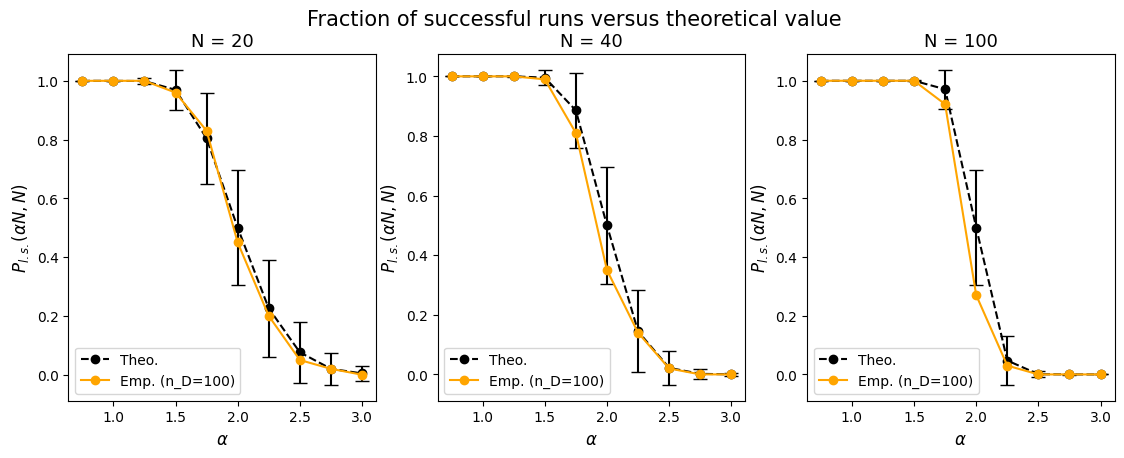

In [ ]:
# Initialize plot dimensions

num_plots = len(N_list)
cols = 3
rows = int(np.ceil(num_plots / cols)) # Calculate required rows
scale = 4.5

# Begin real plotting

fig, axes = plt.subplots(rows, cols, figsize=(scale * cols, scale * rows))

for i, ax in enumerate(axes.flatten()):
    if i < num_plots:
        # Compute 95% CI on simulations based on the CLT
        CI_len = 2* norm.ppf(0.975) * np.sqrt(P_ls_list[i,] * (1 - P_ls_list[i,])) / np.sqrt(n_D)

        # Plot
        ax.plot(alpha_round_list[i,], P_ls_list[i,], '-o', label="Theo.", color="black",
                linestyle="--")
        ax.errorbar(alpha_round_list[i,], P_ls_list[i,], yerr=CI_len, color="black",
                    capsize=5, linestyle="none")
        ax.plot(alpha_round_list[i,], Q_ls_list[i,], '-o', label=f"Emp. (n_D={n_D})", color="orange")

        ax.set_xlabel(r"$\alpha$", fontsize=12)
        ax.set_ylabel(r"$P_{l.s.}(\alpha N, N)$", fontsize=12)
        ax.set_title(f"N = {N_list[i]}", fontsize=13)

        ax.legend()

    # Hide unfilled cells
    else:
        ax.axis('off')

plt.suptitle("Fraction of successful runs versus theoretical value", fontsize=15)
plt.show()

**Discussion**

- The agreement between theory and experiment is pretty reasonable! However, we can notice a trend of significant underestimation by the empirical curve, especially when $P > N$ and $N$ is large. We believe that this is caused by the perceptron fitting procedure not converging within $n_{max}$ epochs. A data set may be linearly separable, but the algorithm not to converge to a solution in the allocated amount of time. The problem worsens the more data is available to be fitted
- Due to the stochastic nature of the empirical process, we also expect a bias term of order $(1/\sqrt{n_D}) \sqrt{P_{l.s.}(\alpha N, N) (1 - P_{l.s.}(\alpha N, N))} \cdot Z$, where $Z$ has the standard normal distribution. The derivation follows via the Central Limit Theorem. The deviation is strongest for $P_{l.s.}$ values close to $0.5$

# Bonus

We choose to follow the first bonus: investigating the shape of $Q_{l.s.}$ when $N$ is large. The code is very similar to that of the regular exercise. We copy it with minimal modifications

In [ ]:
# Redefine the parameters

n_D = 100
n_max = 100
alpha_list = np.arange(1.5,2.6,0.1)
N_list = np.array([100 , 500 , 1000])

In [ ]:
# - Determine the fraction of separable data sets empirically and analytically

# Running time:

P_ls_list = np.empty((len(N_list), len(alpha_list)))
Q_ls_list = np.empty((len(N_list), len(alpha_list)))
alpha_round_list = np.empty((len(N_list), len(alpha_list)))

for i in range(len(N_list)):

  print(i)

  N = N_list[i]
  P_list = np.round(N * alpha_list).astype(np.int_)
  print(P_list)
  alpha_round_list[i,] = P_list/N    # May differ from alpha_list slightly due to rounding
  P_ls_list[i,] = np.array([get_Pls(P, N) for P in P_list])
  print('P done')
  Q_ls_list[i,] = np.array([get_Qls(P, N, seed=42, n_runs = n_D, n_max = n_max) for P in P_list])

KeyboardInterrupt: 

In [ ]:
# Initialize plot dimensions

num_plots = len(N_list)
cols = 3
rows = int(np.ceil(num_plots / cols)) # Calculate required rows
scale = 4.5

# Begin real plotting

fig, axes = plt.subplots(rows, cols, figsize=(scale * cols, scale * rows))

for i, ax in enumerate(axes.flatten()):
    if i < num_plots:
        # Compute 95% CI on simulations based on the CLT
        # CI_len = 2* norm.ppf(0.975) * np.sqrt(P_ls_list[i,] * (1 - P_ls_list[i,])) / np.sqrt(n_D)

        # Plot
        ax.plot(alpha_round_list[i,], P_ls_list[i,], '-o', label="Theo.", color="black", linestyle="--")
        # ax.errorbar(alpha_round_list[i,], P_ls_list[i,], yerr=CI_len, color="black", capsize=2, linestyle="none")
        ax.plot(alpha_round_list[i,], Q_ls_list[i,], '-o', label=f"Emp. (n_D={n_D})", color="orange")

        ax.set_xlabel(r"$\alpha$", fontsize=12)
        ax.set_ylabel(r"$P_{l.s.}(\alpha N, N)$", fontsize=12)
        ax.set_title(f"N = {N_list[i]}", fontsize=13)

        ax.legend()

    # Hide unfilled cells
    else:
        ax.axis('off')

plt.suptitle("Fraction of successful runs versus theoretical value", fontsize=15)
plt.show()